In [1]:
import pandas as pd
import numpy as np
import torch
import os

dataset_path = './dataset/'
dataset_files = ['TcData.csv' ,'BsData.csv']

dfs = dict([])
for file in dataset_files:
    df = pd.read_csv(os.path.join(dataset_path,file), na_values=0)
    df = df.rename(columns={'Composition': 'formula'})
    df.name = file[:2]
    dfs[df.name] = df

In [2]:
dfs['Tc'].describe()

,Annealing Time (s),Annealing Temperature (K),Thickness (mu m),Tc (K)
count,98.000000,98.000000,220.000000,220.000000
mean,1668.527573,735.758597,21.677273,599.232518
std,1439.796336,74.034270,3.351607,73.767177
min,60.000000,573.000000,17.500000,370.000000
25%,240.000000,679.500000,20.000000,587.000000
50%,1800.000000,745.514655,20.000000,605.983795
75%,3600.000000,780.500000,22.500000,626.768258
max,3857.047930,924.632090,30.000000,769.000000


In [3]:
dfs['Bs'].describe()

,Annealing Time (s),Annealing Temperature (K),Thickness (mu m),Bs (T)
count,242.000000,242.000000,294.000000,294.000000
mean,1214.834711,707.543060,23.423469,1.556457
std,1137.973090,88.279149,5.147990,0.281092
min,60.000000,543.000000,13.000000,0.259860
25%,600.000000,630.000000,20.000000,1.473255
50%,600.000000,703.348170,22.000000,1.650000
75%,1800.000000,773.000000,25.000000,1.738235
max,3840.000000,973.000000,76.000000,1.888650


In [4]:
from utils import add_feature

load_df = True
for df_name, df in dfs.items():
    if load_df:
        dfs[df_name] = pd.read_pickle(os.path.join(dataset_path, f"./df_data_{df.name}.pkl"))
    else:    
        name = df.name
        df = add_feature.add_composition(df)
        df = add_feature.add_element_fraction(df)
        df.name = name
        dfs[df_name] = df 
        df.to_pickle(os.path.join(dataset_path, f"./df_data_{df.name}.pkl"))

In [5]:
dfs['Tc'].describe()

,Annealing Time (s),Annealing Temperature (K),Thickness (mu m),Tc (K),H,He,Li,Be,B,C,...,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr
count,98.000000,98.000000,220.000000,220.000000,220.0,220.0,220.0,220.0,220.000000,220.000000,...,220.0,220.0,220.0,220.0,220.0,220.0,220.0,220.0,220.0,220.0
mean,1668.527573,735.758597,21.677273,599.232518,0.0,0.0,0.0,0.0,0.087652,0.013330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1439.796336,74.034270,3.351607,73.767177,0.0,0.0,0.0,0.0,0.037477,0.023594,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,60.000000,573.000000,17.500000,370.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,240.000000,679.500000,20.000000,587.000000,0.0,0.0,0.0,0.0,0.075000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1800.000000,745.514655,20.000000,605.983795,0.0,0.0,0.0,0.0,0.090000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,3600.000000,780.500000,22.500000,626.768258,0.0,0.0,0.0,0.0,0.100000,0.020000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,3857.047930,924.632090,30.000000,769.000000,0.0,0.0,0.0,0.0,0.235625,0.090000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
from utils.surrogate import surrogate_model

Tc_surrogate = surrogate_model(name='Tc', df=dfs['Tc'])
Bs_surrogate = surrogate_model(name='Bs', df=dfs['Bs'])

In [7]:
Tc_surrogate.cleanup_df(drop_NaN = False, drop_col_with_NaN = True)
Bs_surrogate.cleanup_df(drop_NaN = False, drop_col_with_NaN = True)
Tc_surrogate.split_train_test(test_size=0.2,seed=1)
Bs_surrogate.split_train_test(test_size=0.2, seed=1)

In [8]:
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
#from botorch.fit import fit_gpytorch_mll
from torch.optim import SGD, Adam
from botorch.models.transforms.input import ChainedInputTransform
from utils.model import trainGP, NormalizeElementFractions, NormalizeFeatures
from utils.model import test_features_normalized

for surrogate_model in [Tc_surrogate, Bs_surrogate]:
    surrogate_model.model = None
    outcome_transform = Standardize(m=1)
    normalize_other = NormalizeFeatures(indices=surrogate_model.to_scale_col)
    normalize_EF = NormalizeElementFractions(indices=surrogate_model.EF_col)
    input_transform = ChainedInputTransform(
        tf1=normalize_other, 
        tf2=normalize_EF,
    )
    
    surrogate_model.model = SingleTaskGP(
        torch.tensor(surrogate_model.X_train), 
        torch.tensor(surrogate_model.y_train).unsqueeze(dim=1),
        input_transform=input_transform,
        outcome_transform=outcome_transform,
        covar_module=ScaleKernel(RBFKernel()),
    )
    
    surrogate_model.test_invariance()

/Users/jingsk/software/Fe_alloy_phaseshift/utils/model.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = model.posterior(torch.tensor(X, dtype=torch.double))


Model Tc is invariance to scaling non-ratio features: True
Model Tc is invariance to scaling elemental fractions: True
Model Bs is invariance to scaling non-ratio features: True
Model Bs is invariance to scaling elemental fractions: True


-------------------
Training Tc_GP.torch
Epoch 100/600 - Loss: 1.430 noise: 1.293
Epoch 200/600 - Loss: 1.331 noise: 0.729
Epoch 300/600 - Loss: 1.001 noise: 0.207
Epoch 400/600 - Loss: 0.807 noise: 0.112
Epoch 500/600 - Loss: 0.799 noise: 0.109
Epoch 600/600 - Loss: 0.796 noise: 0.109
train R2 =  0.924
train RMSE = 20.055
test R2 =  0.852
test RMSE = 31.802
-------------------
-------------------
Training Bs_GP.torch
Epoch 100/600 - Loss: 1.366 noise: 1.188
Epoch 200/600 - Loss: 1.234 noise: 0.574
Epoch 300/600 - Loss: 1.124 noise: 0.420
Epoch 400/600 - Loss: 0.786 noise: 0.123
Epoch 500/600 - Loss: 0.731 noise: 0.106
Epoch 600/600 - Loss: 0.730 noise: 0.106
train R2 =  0.927
train RMSE = 0.080
test R2 =  0.724
test RMSE = 0.119
-------------------


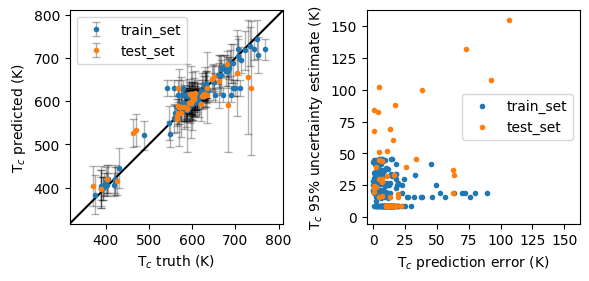

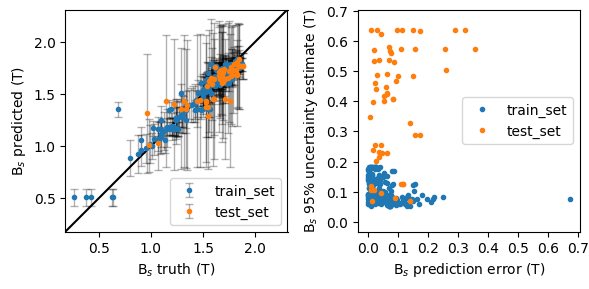

In [9]:
load_state = False

for surrogate_model in [Tc_surrogate, Bs_surrogate]:
    print("-------------------")
    #surrogate_model.model.train()
    model_path = './models/'
    model_name = surrogate_model.name + '_GP.torch'
    
    if load_state:
        surrogate_model.model.load_state_dict(torch.load(os.path.join(model_path,model_name)))
        surrogate_model.model.eval()
    
    else:
        surrogate_model.model.train()
        #optimizer_kwargs = {'lr': 1e-2, 'weight_decay': 1e-3}
        optimizer_kwargs = {'lr': 5e-2, 'weight_decay': 1e-4}
        print(f"Training {model_name}")
        #surrogate_model.model.train()
        trainGP(surrogate_model.model,
                mll = ExactMarginalLogLikelihood(surrogate_model.model.likelihood, surrogate_model.model), 
                optimizer = SGD([{'params': surrogate_model.model.parameters()}], **optimizer_kwargs),
                num_epochs=600,
                print_interval = 100 
               )
        torch.save(surrogate_model.model.state_dict(), os.path.join(model_path,model_name))
        surrogate_model.evaluate_train_test_fit()
        surrogate_model.plot_train_test_fit()
        print("-------------------")